# Audio spectrogram

## Background

In this example we will go through the steps to build a DALI audio processing pipeline, including the calculation of a spectrogram. A spectrogram is a representation of a signal (e.g. an audio signal) that shows the evolution of the frequency spectrum in time.

Typically, a spectrogram is calculated by computing the fast fourier transform (FFT) over a series of overlapping windows extracted from the original signal. The process of dividing the signal in short term sequences of fixed size and applying FFT on those independently is called Short-time Fourier transform (STFT). The spectrogram is then calculated as the (typically squared) complex magnitude of the STFT.

Extracting short term windows of the original signal affects the calculated spectrum by producing aliasing artifacts. This is often called spectral leakage. To control/reduce the spectral leakage effect, we use different window functions when extracting the windows. Some examples of window functions are: Hann, Hanning, etc.

It is beyond the scope of this example to go deeper into the details of the signal processing concepts we mentioned above. More information can be found here:
- [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)
- [Window functions](https://en.wikipedia.org/wiki/Window_function)

## Reference implementation

To verify the correctness of DALI's implementation, we will compare it against librosa (https://librosa.github.io/librosa/).

In [1]:
import os
from pathlib import Path

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

import nvidia.dali.experimental.dynamic as ndd

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

Librosa provides an API to calculate the STFT, producing a complex output (i.e. complex numbers). It is then trivial to calculate the power spectrum from the complex STFT by the following.

In [2]:
dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
sample_data = dali_extra_dir / "db" / "audio" / "wav" / "237-134500-0000.wav"

# Size of the FFT, which will also be used as the window length
n_fft = 2048

# Step or stride between windows. If the step is smaller than the window length,
# the windows will overlap
hop_length = 512

# Load sample audio file
y, sr = librosa.load(sample_data)

# Calculate the spectrogram as the square of the complex magnitude of the STFT
spectrogram_librosa = (
    np.abs(
        librosa.stft(
            y,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=n_fft,
            window="hann",
            pad_mode="reflect",
        )
    )
    ** 2
)

We can now transform the spectrogram output to a logarithmic scale by transforming the amplitude to decibels. While doing so we will also normalize the spectrogram so that its maximum represents the 0 dB point.

In [3]:
spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)

The last step is to display the spectrogram

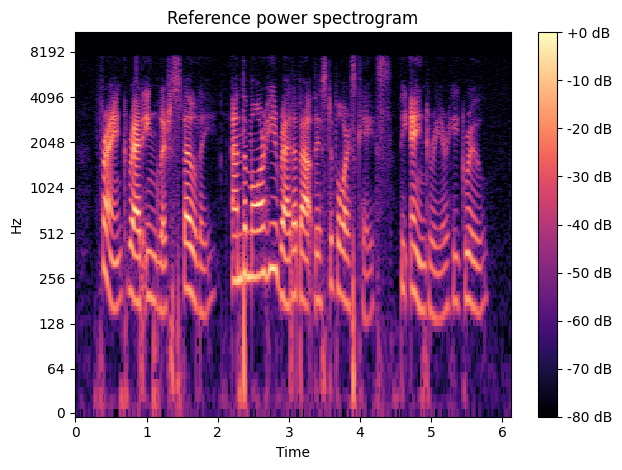

In [4]:
def show_spectrogram(spec, title, sr, hop_length, y_axis="log", x_axis="time"):
    librosa.display.specshow(
        spec, sr=sr, y_axis=y_axis, x_axis=x_axis, hop_length=hop_length
    )
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()


show_spectrogram(
    spectrogram_librosa_db, "Reference power spectrogram", sr, hop_length
)

## Calculating the Spectrogram using DALI

To demonstrate DALI's [spectrogram](../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.spectrogram.html) operator we will pass the audio data directly to the operator. In dynamic mode, we can convert numpy arrays to GPU tensors using `ndd.as_tensor()`.

In [5]:
audio_data = ndd.as_tensor(y, device="gpu")

spectrogram_dali = ndd.spectrogram(
    audio_data,
    device="gpu",
    nfft=n_fft,
    window_length=n_fft,
    window_step=hop_length,
)

and display it as we did with the reference implementation

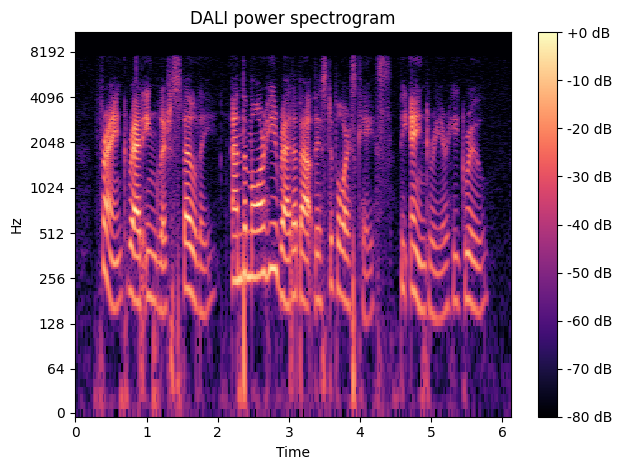

In [6]:
spectrogram_dali_db = librosa.power_to_db(spectrogram_dali.cpu(), ref=np.max)
show_spectrogram(spectrogram_dali_db, "DALI power spectrogram", sr, hop_length)

As a last sanity check, we can verify that the numerical difference between the reference implementation and DALI's is insignificant

In [7]:
print(
    "Average error: {0:.5f} dB".format(
        np.mean(np.abs(spectrogram_dali_db - spectrogram_librosa_db))
    )
)
assert np.allclose(spectrogram_dali_db, spectrogram_librosa_db, atol=2)

Average error: 0.00494 dB


## Mel Spectrogram

The mel scale is a non-linear transformation of frequency scale based on the perception of pitches. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as being equidistant. More information can be found here: https://en.wikipedia.org/wiki/Mel_scale.

In machine learning applications involving speech and audio, we typically want to represent the power spectrogram in the mel scale domain. We do that by applying a bank of overlapping triangular filters that compute the energy of the spectrum in each band.

Typically, we want the mel spectrogram represented in decibels. We can calculate a mel spectrogram in decibels using DALI operators.

In [8]:
spectrogram = ndd.spectrogram(
    audio_data,
    device="gpu",
    nfft=n_fft,
    window_length=n_fft,
    window_step=hop_length,
)
mel_spectrogram = ndd.mel_filter_bank(
    spectrogram, sample_rate=sr, nfilter=128, freq_high=8000.0
)
mel_spectrogram_dali_db = np.asarray(
    ndd.to_decibels(mel_spectrogram, multiplier=10.0, cutoff_db=-80).cpu()
)

We can now verify that it produces the same result as Librosa

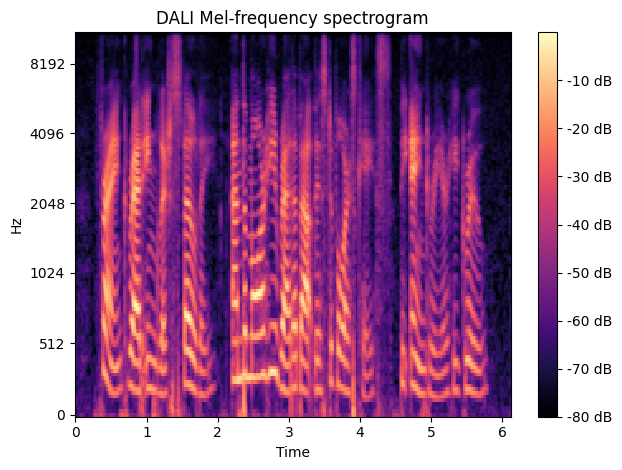

In [9]:
show_spectrogram(
    mel_spectrogram_dali_db,
    "DALI Mel-frequency spectrogram",
    sr,
    hop_length,
    y_axis="mel",
)

In [10]:
mel_spectrogram_librosa = librosa.feature.melspectrogram(
    y=y, sr=sr, n_mels=128, fmax=8000, pad_mode="reflect"
)
mel_spectrogram_librosa_db = librosa.power_to_db(
    mel_spectrogram_librosa, ref=np.max
)
assert np.allclose(mel_spectrogram_dali_db, mel_spectrogram_librosa_db, atol=1)

## Mel-Frequency Cepstral Coefficients (MFCCs)

MFCCs are an alternative representation of the Mel-frequency spectrogram often used in audio applications. The MFCCs are calculated by applying the discrete cosine transform (DCT) to a mel-frequency spectrogram. 

DALI's implementation of DCT uses the formulas described in https://en.wikipedia.org/wiki/Discrete_cosine_transform


In addition to the DCT, a cepstral filter (also known as *liftering*) can be applied to emphasize higher order coefficients.

A *liftered* cepstral coefficient is calculated according to the formula
$$
\widehat{\text{MFCC}_i} = w_{i} \cdot \text{MFCC}_{i}
$$
where
$$
w_i = 1 + \frac{L}{2}\sin\Big(\frac{\pi i}{L}\Big)
$$
where $L$ is the *liftering* coefficient.

More information about MFCC can be found here: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum.

We can use DALI's MFCC operator to transform the mel-spectrogram into a set of MFCCs

In [11]:
spectrogram = ndd.spectrogram(
    audio_data,
    device="gpu",
    nfft=n_fft,
    window_length=n_fft,
    window_step=hop_length,
)
mel_spectrogram = ndd.mel_filter_bank(
    spectrogram, sample_rate=sr, nfilter=128, freq_high=8000.0
)
mel_spectrogram_db = ndd.to_decibels(
    mel_spectrogram, multiplier=10.0, cutoff_db=-80
)
mfccs_dali = np.asarray(
    ndd.mfcc(
        mel_spectrogram_db,
        axis=0,
        dct_type=2,
        n_mfcc=40,
        normalize=True,
        lifter=0,
    ).cpu()
)

Let's now display the output as we did previously

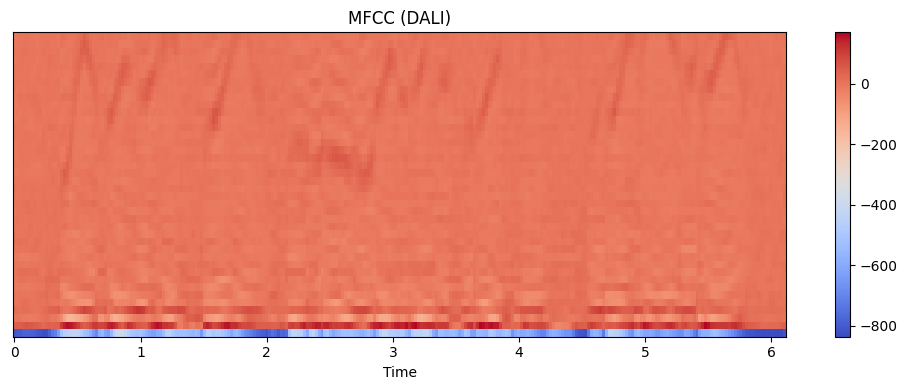

In [12]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_dali, x_axis="time")
plt.colorbar()
plt.title("MFCC (DALI)")
plt.tight_layout()
plt.show()

As a last step, let's verify that this implementation produces the same result as Librosa. Please note, we are comparing the ortho-normalized MFCCs, as Librosa's DCT implementation uses a different formula which causes the output to be scaled by a factor of 2 when we compare it with the Wikipedia's formulae. 

In [13]:
mfccs_librosa = librosa.feature.mfcc(
    S=mel_spectrogram_librosa_db, dct_type=2, n_mfcc=40, norm="ortho", lifter=0
)
assert np.allclose(mfccs_librosa, mfccs_dali, atol=1)